# Using cosine distances in input space

In our default scRNA-seq workflow, we apply a standard normalisation and scaling procedure followed by a PCA reduction to 100 PCs (this is described in our manuscript, in our [comparative analysis set-up](https://github.com/saeyslab/ViScore/tree/main/benchmarking) and in the `example_scrnaseq.ipynb` tutorial).
The PCA step speeds up training of embedding models and reduces sparsity of data.
We make the deliberate decision thereafter to use Euclidean distances in input (PC) space for our MDS loss, de-noising and RNX curve construction.
This is to be able to capture differences in magnitude between vectors in the PC space and to retain sensitivity to outliers.

However, some practitioners may prefer the use of *cosine distances* for determining distances in input space.
Cosine distances are less sensitive to outliers and effectively normalise the scales of each feature.
This may be relevant in de-sensitising the DR model against outliers or noise.
We give the option to configure the stochastic-MDS loss (responsible for multi-scale structure preservation) to use cosine distances in input space.

We show an example of using cosine distances with the [*Farrell*](https://www.science.org/doi/10.1126/science.aar3131) and [*Reed*](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637) data, revealing an artifact that this setting introduces.

In [34]:
import numpy as np
import torch
import ViVAE

The [*Farrell*](https://www.science.org/doi/10.1126/science.aar3131) data is downloaded from the Single Cell Portal (accession code `SCP162`).

The [*Reed*](https://www.nature.com/articles/s41588-024-01688-9) data is downloaded from CELLxGENE.

Both datasets are pre-processed as described [here](https://github.com/saeyslab/ViScore/tree/main/benchmarking#6-vivae-benchmark-specifications), in our manuscript and in `example_scrnaseq.ipynb`.

In [37]:
input_farrell = np.load('../../ViScore/benchmarking/data/Farrell_input_denoised.npy', allow_pickle=True) # de-noised
labs_farrell  = np.load('../../ViScore/benchmarking/data/Farrell_labels.npy', allow_pickle=True)
input_reed = np.load('../../ViScore/benchmarking/data/Reed_input_denoised.npy', allow_pickle=True) # de-noised
labs_reed  = np.load('../../ViScore/benchmarking/data/Reed_labels.npy', allow_pickle=True)

We fit ViVAE models with MDS distance functions specified using `mds_distf_hd` and `mds_distf_ld`.

In [38]:
np.random.seed(42)
torch.manual_seed(42)
model_farrell = ViVAE.ViVAE(input_dim=input_farrell.shape[1], latent_dim=2, random_state=42)
model_farrell.fit(input_farrell, n_epochs=20, batch_size=1024, lam_recon=10., lam_kldiv=1., lam_mds=100., mds_distf_hd='cosine', mds_distf_ld='euclidean', verbose=False)

np.random.seed(42)
torch.manual_seed(42)
model_reed = ViVAE.ViVAE(input_dim=input_reed.shape[1], latent_dim=2, random_state=42)
model_reed.fit(input_reed, n_epochs=20, batch_size=1024, lam_recon=10., lam_kldiv=1., lam_mds=100., mds_distf_hd='cosine', mds_distf_ld='euclidean', verbose=False)

Epoch 1/20	recon: 2585.1395	kldiv: 0.1750	geom: 0.0000	egeom: 0.0000	mds: 824.5732	imit: 0.0000
Epoch 2/20	recon: 909.3050	kldiv: 0.2735	geom: 0.0000	egeom: 0.0000	mds: 166.4628	imit: 0.0000
Epoch 3/20	recon: 444.6229	kldiv: 0.2247	geom: 0.0000	egeom: 0.0000	mds: 80.3819	imit: 0.0000
Epoch 4/20	recon: 287.4577	kldiv: 0.2122	geom: 0.0000	egeom: 0.0000	mds: 43.1552	imit: 0.0000
Epoch 5/20	recon: 197.9380	kldiv: 0.2637	geom: 0.0000	egeom: 0.0000	mds: 21.1344	imit: 0.0000
Epoch 6/20	recon: 149.9876	kldiv: 0.3039	geom: 0.0000	egeom: 0.0000	mds: 15.6570	imit: 0.0000
Epoch 7/20	recon: 117.1104	kldiv: 0.3181	geom: 0.0000	egeom: 0.0000	mds: 13.4992	imit: 0.0000
Epoch 8/20	recon: 95.5110	kldiv: 0.3157	geom: 0.0000	egeom: 0.0000	mds: 11.8413	imit: 0.0000
Epoch 9/20	recon: 79.6512	kldiv: 0.3058	geom: 0.0000	egeom: 0.0000	mds: 10.4460	imit: 0.0000
Epoch 10/20	recon: 61.6082	kldiv: 0.3185	geom: 0.0000	egeom: 0.0000	mds: 9.3990	imit: 0.0000
Epoch 11/20	recon: 48.3823	kldiv: 0.3333	geom: 0.0000	egeom:

We can now transform our de-noised inputs and plot the embeddings.

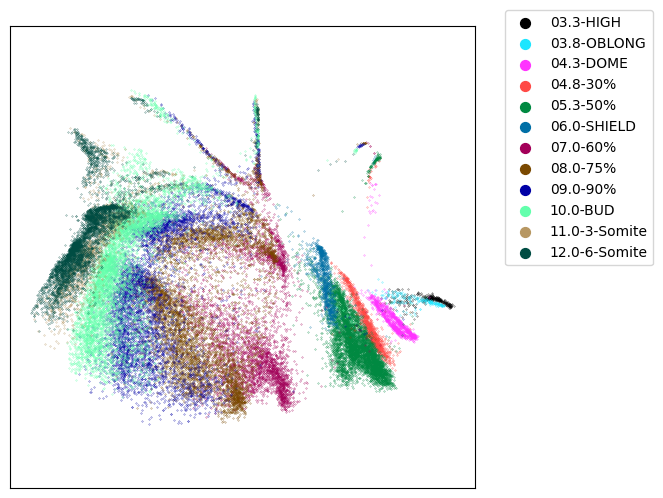

In [80]:
emb_farrell = model_farrell.transform(input_farrell)
fig_farrell, ax_farrell = ViVAE.plot_embedding(emb_farrell, labs_farrell)
ax_farrell.get_legend().remove()
ax_farrell.set_title('Farrell: ViVAE with cosine-MDS')
fig_farrell.savefig('cosine_farrell_labels.png', dpi=600)

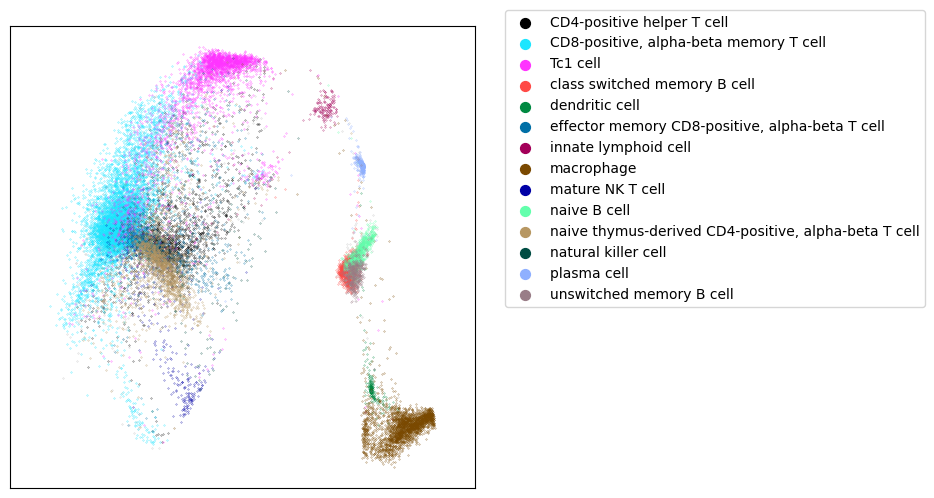

In [81]:
emb_reed = model_reed.transform(input_reed)
fig_reed, ax_reed = ViVAE.plot_embedding(emb_reed, labs_reed, unassigned='unknown')
ax_reed.get_legend().remove()
ax_reed.set_title('Reed: ViVAE with cosine-MDS')
fig_reed.savefig('cosine_reed_labels.png', dpi=600)

We proceed to compute and plot encoder indicatrices to reveal latent space distortions.

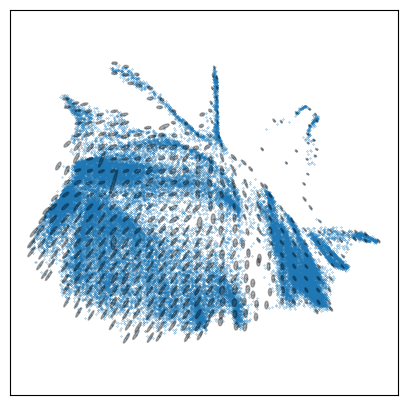

In [76]:
ei_farrell = model_farrell.encoder_indicatrices(X=input_farrell, radius=1e-3, n_steps=30)
fig_farrel_ei, ax_farrell_ei = ViVAE.plot_indicatrices(ei_farrell, scale_factor=3e2, show=True)
ax_farrell_ei.set_title('Latent space distortions')
fig_farrel_ei.savefig('cosine_farrell_indicatrices.png', dpi=600)

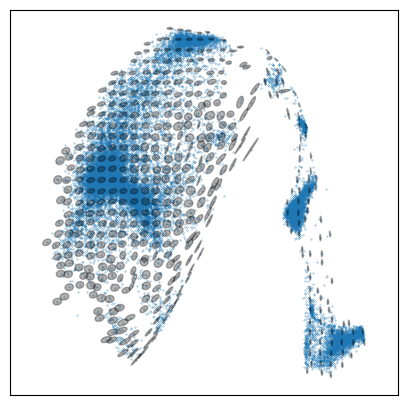

In [77]:
ei_reed = model_reed.encoder_indicatrices(X=input_reed, radius=1e-4, n_steps=30)
fig_reed_ei, ax_reed_ei = ViVAE.plot_indicatrices(ei_reed, scale_factor=1e3, show=True)
ax_reed_ei.set_title('Latent space distortions')
fig_reed_ei.savefig('cosine_reed_indicatrices.png', dpi=600)

In [71]:
emb_farrell = model_farrell.transform(input_farrell)
fig_farrell, ax_farrell = ViVAE.plot_embedding(emb_farrell, labs_farrell, show=False)
fig_farrell.savefig('cosine_farrell_legend.png', dpi=600, bbox_inches='tight')

In [73]:
emb_reed = model_reed.transform(input_reed)
fig_reed, ax_reed = ViVAE.plot_embedding(emb_reed, labs_reed, show=False, unassigned='unknown')
fig_reed.savefig('cosine_reed_legend.png', dpi=600, bbox_inches='tight')